# Static maps  with matplotlib

- https://kodu.ut.ee/~kmoch/geopython2020/L6/static-maps.html

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# Filepaths
grid_fp = "population_square_km.shp"

roads_fp = "roads.shp"

schools_fp = "schools_tartu.shp"

# Read files
grid = gpd.read_file(grid_fp)

roads = gpd.read_file(roads_fp)

schools = gpd.read_file(schools_fp)

In [70]:
gridCRS = grid.crs
roads['geometry'] = roads['geometry'].to_crs(crs=gridCRS)
schools['geometry'] = schools['geometry'].to_crs(crs=gridCRS)

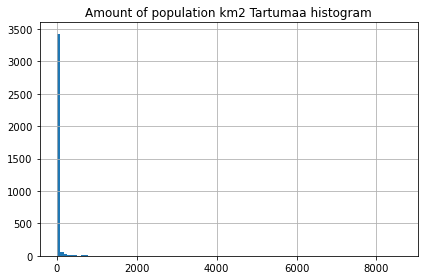

In [71]:
# Plot
grid.hist(column="Population", bins=100)
# Add title
plt.title("Amount of population km2 Tartumaa histogram")
plt.tight_layout()

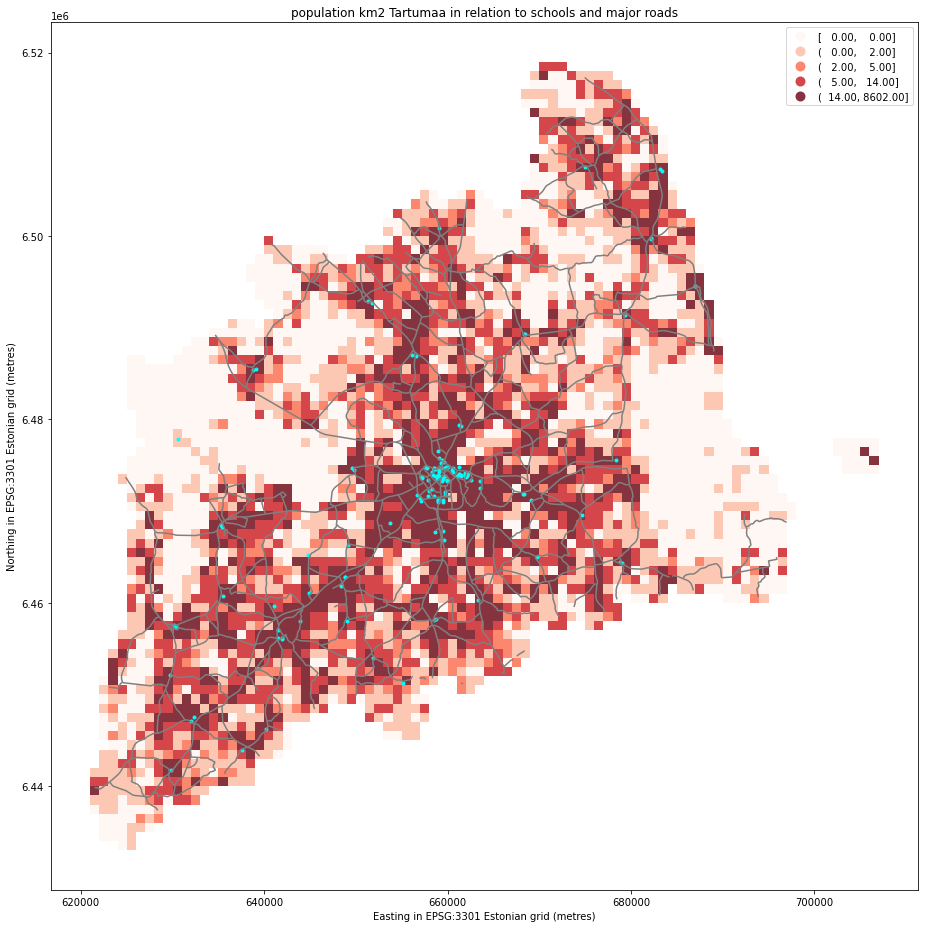

In [72]:
fig, ax = plt.subplots(figsize=(15, 13))

# Visualize the population density into 5 classes using "Quantiles" classification scheme
# Add also a little bit of transparency with `alpha` parameter
# (ranges from 0 to 1 where 0 is fully transparent and 1 has no transparency)
grid.plot(column="Population", ax=ax, linewidth=0.03, cmap="Reds", scheme="quantiles", k=5, alpha=0.8, legend=True)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add schools on top of the previous map
schools.plot(ax=ax, color="cyan", markersize=9.0)

# Remove the empty white-space around the axes
plt.title("population km2 Tartumaa in relation to schools and major roads")

ax.set_ylabel('Northing in EPSG:3301 Estonian grid (metres)')
ax.set_xlabel('Easting in EPSG:3301 Estonian grid (metres)')

plt.tight_layout()

In [5]:
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

<Figure size 432x288 with 0 Axes>

### EarthPy DEM and Hillshade raster with normal GeoDataFrame vector data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rio

dtm = '../L5/dem.tif'

# Open the DEM with Rasterio
src = rio.open(dtm)
elevation = src.read(1)

In [7]:
import geopandas as gpd

catchments = gpd.read_file('../L5/porijogi_sub_catchments.geojson')

subcatch = catchments.loc[catchments['NAME_1']=='Idaoja']

# protected species under class 3 monitoring sightings
species_fp = "../L3/category_3_species_porijogi.gpkg"

species_data = gpd.read_file(species_fp, layer='category_3_species_porijogi', driver='GPKG')

In [8]:
pip_mask = species_data.within(subcatch.loc[0, 'geometry'])
pip_data = species_data.loc[pip_mask]

In [9]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import collections

patchList = []

data_key = mpatches.Patch(color="gold", label="Selected Idaoja species")

patchList.append(data_key)
    

In [10]:
hillshade = es.hillshade(elevation)

In [11]:
# to define the bounds of the map (important for the raster layers plot)
extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

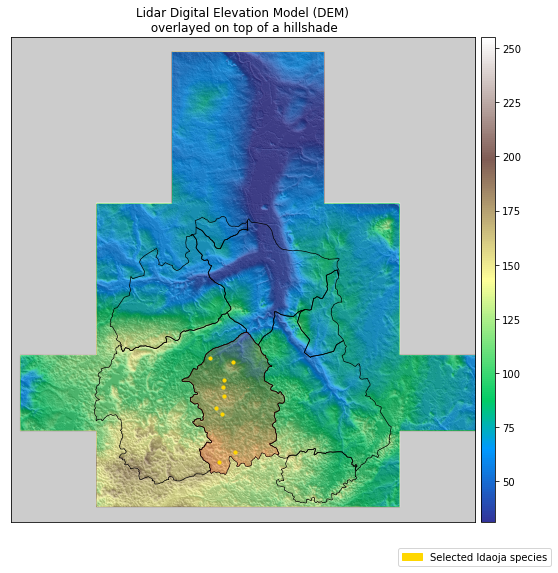

In [110]:
fig, ax = plt.subplots(figsize=(12,8))

ep.plot_bands(elevation, ax=ax, cmap="terrain", extent=extent, title="Lidar Digital Elevation Model (DEM)\n overlayed on top of a hillshade" )

ep.plot_bands(hillshade, cmap='Greys', extent=extent, ax=ax, alpha=0.3, cbar=None)

catchments.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.7)

subcatch.plot(ax=ax, facecolor='red', alpha=0.2)

pip_data.plot(ax=ax, color='gold', markersize=10, legend=True)

plt.legend(handles=patchList, loc='lower center', bbox_to_anchor=(-0.5, -0.1), ncol=1)

plt.tight_layout()

plt.savefig('DEM_hillshade_etc.png')

### Special plots types with GeoPlot

### Using web tile layer as background and use mapclassify directly

https://residentmario.github.io/geoplot/gallery/index.html

https://contextily.readthedocs.io/en/latest/

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

fp = "../L4/population_admin_units.shp"

acc = gpd.read_file(fp)
acc['pop_int'] = acc['population'].apply(pd.to_numeric, errors='coerce').dropna()
acc_wgs84 = acc.to_crs(4326)


In [33]:
import geoplot as gplt
import geoplot.crs as gcrs

In [34]:
import mapclassify as mc

In [35]:
import contextily as ctx

Text(0.5, 1.0, 'Population per municipality')

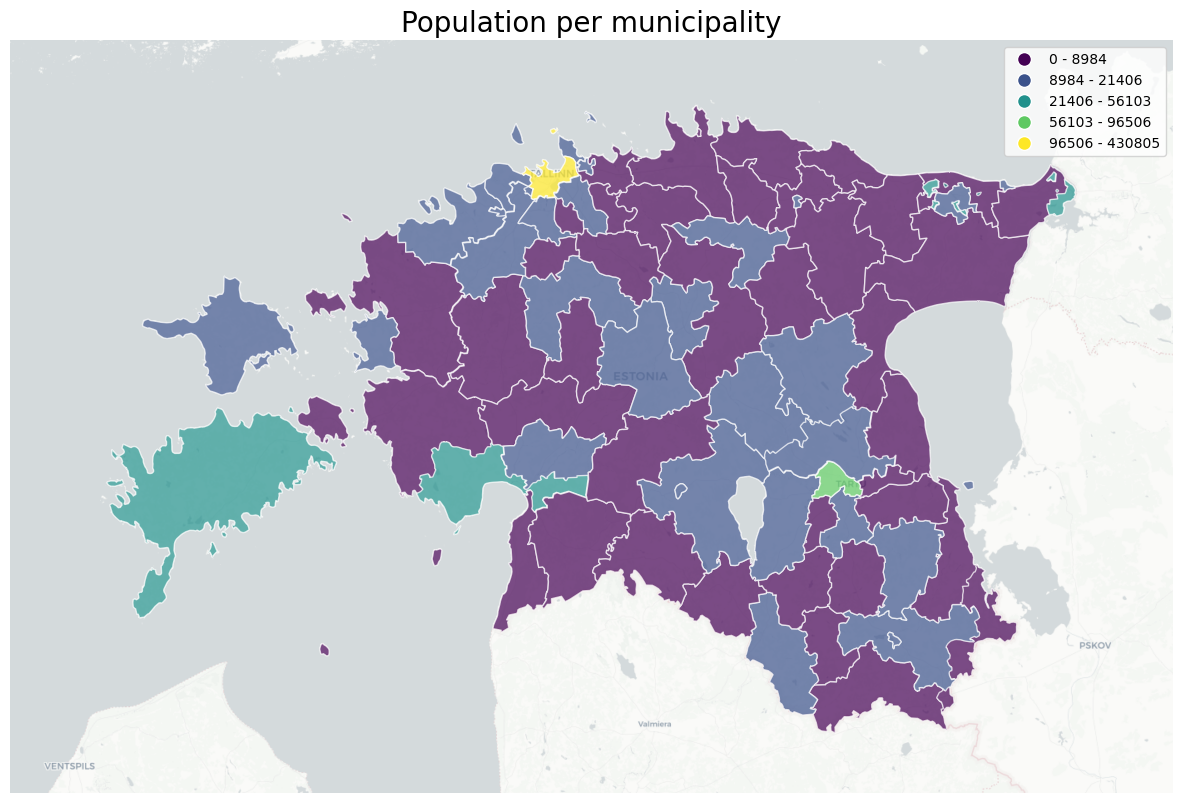

In [36]:
ax = gplt.webmap(df=acc_wgs84, projection=gcrs.WebMercator(), zoom=8, provider=ctx.providers.CartoDB.Positron, figsize=(15,12))

scheme = mc.FisherJenks(acc_wgs84[['pop_int']], k=5)
    
gplt.choropleth(
    acc_wgs84, hue='pop_int', projection=gcrs.WebMercator(),
    edgecolor='white', linewidth=1, alpha=0.7, 
    cmap='viridis', legend=True,
    ax=ax,
    scheme=scheme
)

plt.title("Population per municipality", fontsize=20)

### GeoPlot cartogram, using a variable as scale for size of polygon

https://residentmario.github.io/geoplot/api_reference.html

Text(0.5, 1.0, 'Population per municipality as cartogram')

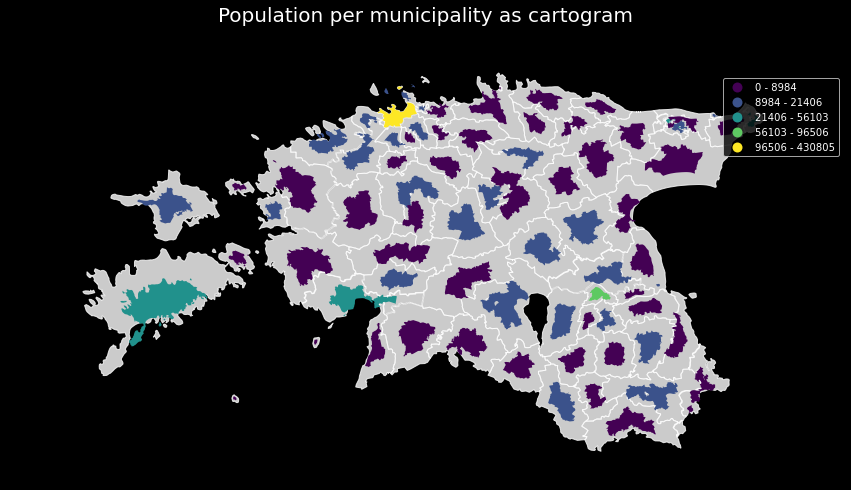

In [18]:
plt.style.use('dark_background')

ax = gplt.cartogram(
    acc_wgs84, scale='pop_int', projection=gcrs.AlbersEqualArea(),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='pop_int',
    scheme=scheme,
    cmap='viridis',
    limits=(0.5, 1),
    figsize=(15,12)
)
gplt.polyplot(acc_wgs84, facecolor='white', edgecolor='white', alpha=0.8, ax=ax)

plt.title("Population per municipality as cartogram", fontsize=20)

### GeoPlot making a static KDE plot as contour or filled

https://residentmario.github.io/geoplot/api_reference.html

In [19]:
plt.style.use('default')

In [20]:
c4 = catchments.to_crs(4326)
s4 = species_data.to_crs(4326)

<Figure size 432x288 with 0 Axes>

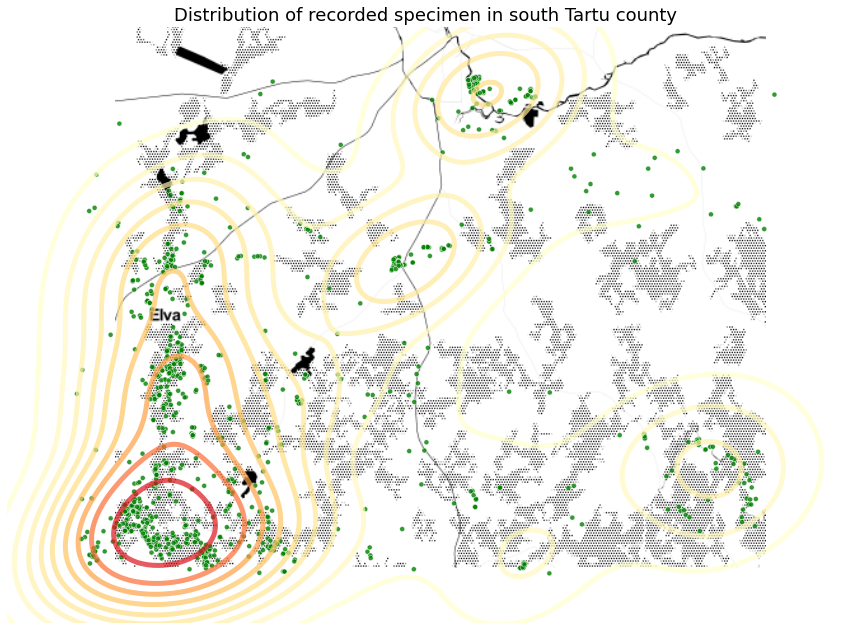

In [109]:
fig = plt.figure()

proj = gcrs.WebMercator()

ax = gplt.webmap(df=gpd.overlay(c4, s4, how='union'), projection=proj, zoom=10, provider=ctx.providers.Stamen.Toner, figsize=(15,12))

ax = gplt.pointplot(s4, projection=proj, color='green', edgecolor='white',  linewidth=0.5, alpha=0.8, ax=ax)

ax = gplt.kdeplot(s4, projection=proj, cmap='YlOrRd', shade=False, linewidths=5, alpha=0.7, ax=ax)

ax.set_title("Distribution of recorded specimen in south Tartu county", fontsize=18)

plt.savefig("species-kde.png", bbox_inches='tight')

C:\dev\conda3\envs\geopy2020\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\dev\conda3\envs\geopy2020\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


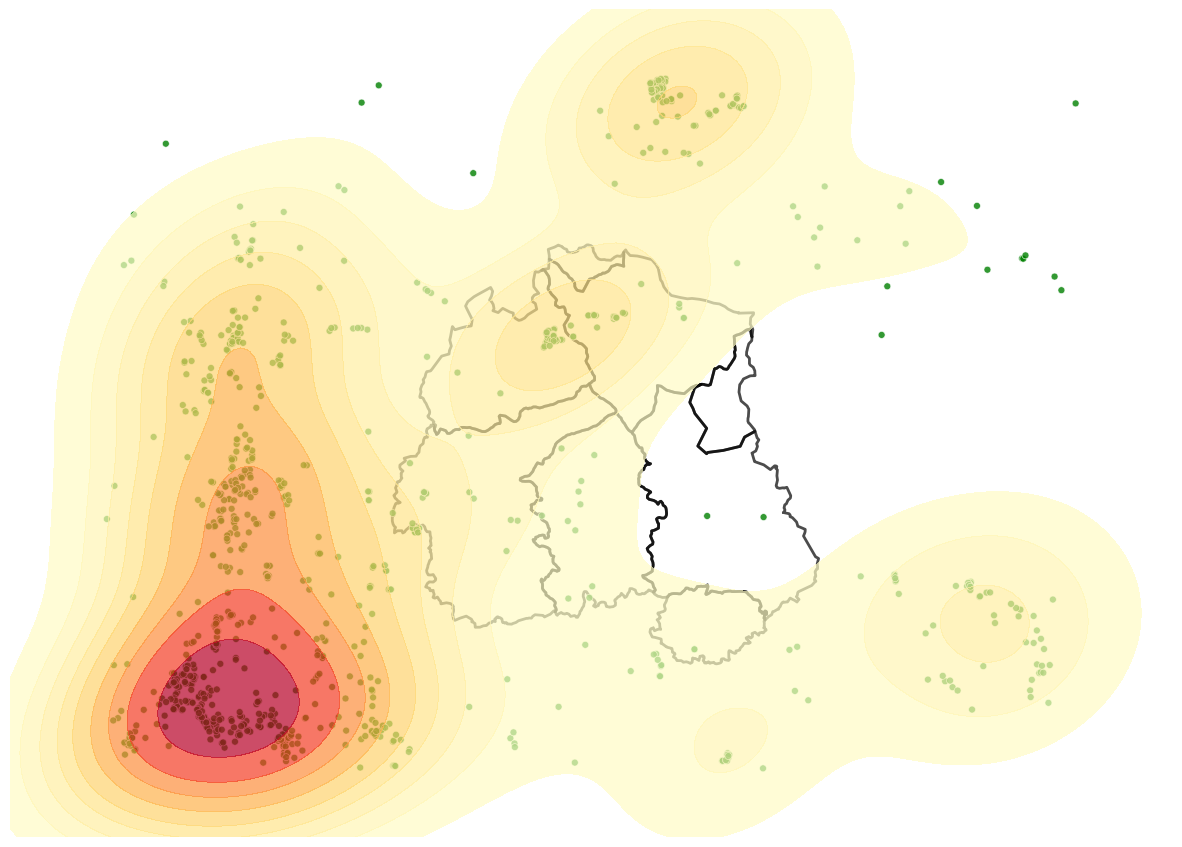

In [22]:
proj = gcrs.AlbersEqualArea()

ax = gplt.pointplot(s4, projection=proj, color='green', edgecolor='white',  linewidth=0.5, alpha=0.8, figsize=(15,12))

ax = gplt.polyplot(c4, projection=proj, edgecolor='black',  linewidth=2, alpha=0.7, ax=ax)

ax = gplt.kdeplot(s4, projection=proj, cmap='YlOrRd', shade=True, alpha=0.7, ax=ax)

In [94]:
import pandas as pd
import geopandas as gpd
import geoviews as gv
import geoviews.feature as gf

from geoviews import opts
from geoviews import tile_sources as gvts
from cartopy import crs

gv.extension('matplotlib')
gv.output(fig='png', size=300)

import warnings
warnings.filterwarnings('ignore')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [95]:
grid84 = grid.to_crs(4326)

roads84 = roads.to_crs(4326)

schools84 = schools.to_crs(4326)

In [99]:
tiles = gvts.CartoEco

In [100]:
shapes = []

for idx, row in roads84.iterrows():
    shapes.append( gv.Shape(row['geometry']).opts(edgecolor='black', lw=1) )

In [116]:
img1 = tiles.opts(zoom=10) * gv.Points(schools84).opts(color='cyan', projection=crs.AlbersEqualArea())

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]
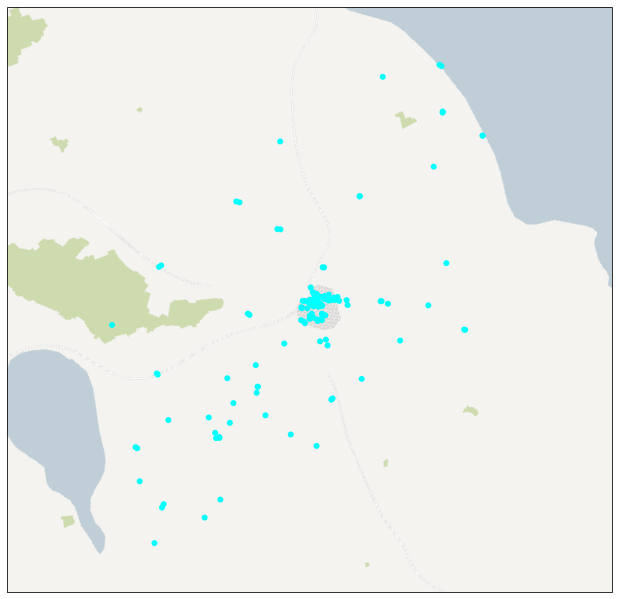

In [117]:
img1

In [118]:
gv.save(img1, 'geoviews-tartu-startic1.png')

:Overlay
   .WMTS.I            :WMTS   [Longitude,Latitude]
   .Shape.I           :Shape   [Longitude,Latitude]
   .Shape.II          :Shape   [Longitude,Latitude]
   .Shape.III         :Shape   [Longitude,Latitude]
   .Shape.IV          :Shape   [Longitude,Latitude]
   .Shape.V           :Shape   [Longitude,Latitude]
   .Shape.VI          :Shape   [Longitude,Latitude]
   .Shape.VII         :Shape   [Longitude,Latitude]
   .Shape.VIII        :Shape   [Longitude,Latitude]
   .Shape.IX          :Shape   [Longitude,Latitude]
   .Shape.X           :Shape   [Longitude,Latitude]
   .Shape.XI          :Shape   [Longitude,Latitude]
   .Shape.XII         :Shape   [Longitude,Latitude]
   .Shape.XIII        :Shape   [Longitude,Latitude]
   .Shape.XIV         :Shape   [Longitude,Latitude]
   .Shape.XV          :Shape   [Longitude,Latitude]
   .Shape.XVI         :Shape   [Longitude,Latitude]
   .Shape.XVII        :Shape   [Longitude,Latitude]
   .Shape.XVIII       :Shape   [Longitude,Latitude]
   .Shape.XIX         :Shape   [Longitude,Latitude]
   .Shape.XX          :Shape   [Longitude,Latitude]
   .Shape.XXI         :Shape   [Longitude,Latitude]
   .Shape.XXII        :Shape   [Longitude,Latitude]
   .Shape.XXIII       :Shape   [Longitude,Latitude]
   .Shape.XXIV        :Shape   [Longitude,Latitude]
   .Shape.XXV         :Shape   [Longitude,Latitude]
   .Shape.XXVI        :Shape   [Longitude,Latitude]
   .Shape.XXVII       :Shape   [Longitude,Latitude]
   .Shape.XXVIII      :Shape   [Longitude,Latitude]
   .Shape.XXIX        :Shape   [Longitude,Latitude]
   .Shape.XXX         :Shape   [Longitude,Latitude]
   .Shape.XXXI        :Shape   [Longitude,Latitude]
   .Shape.XXXII       :Shape   [Longitude,Latitude]
   .Shape.XXXIII      :Shape   [Longitude,Latitude]
   .Shape.XXXIV       :Shape   [Longitude,Latitude]
   .Shape.XXXV        :Shape   [Longitude,Latitude]
   .Shape.XXXVI       :Shape   [Longitude,Latitude]
   .Shape.XXXVII      :Shape   [Longitude,Latitude]
   .Shape.XXXVIII     :Shape   [Longitude,Latitude]
   .Shape.XXXIX       :Shape   [Longitude,Latitude]
   .Shape.XL          :Shape   [Longitude,Latitude]
   .Shape.XLI         :Shape   [Longitude,Latitude]
   .Shape.XLII        :Shape   [Longitude,Latitude]
   .Shape.XLIII       :Shape   [Longitude,Latitude]
   .Shape.XLIV        :Shape   [Longitude,Latitude]
   .Shape.XLV         :Shape   [Longitude,Latitude]
   .Shape.XLVI        :Shape   [Longitude,Latitude]
   .Shape.XLVII       :Shape   [Longitude,Latitude]
   .Shape.XLVIII      :Shape   [Longitude,Latitude]
   .Shape.XLIX        :Shape   [Longitude,Latitude]
   .Shape.L           :Shape   [Longitude,Latitude]
   .Shape.LI          :Shape   [Longitude,Latitude]
   .Shape.LII         :Shape   [Longitude,Latitude]
   .Shape.LIII        :Shape   [Longitude,Latitude]
   .Shape.LIV         :Shape   [Longitude,Latitude]
   .Shape.LV          :Shape   [Longitude,Latitude]
   .Shape.LVI         :Shape   [Longitude,Latitude]
   .Shape.LVII        :Shape   [Longitude,Latitude]
   .Shape.LVIII       :Shape   [Longitude,Latitude]
   .Shape.LIX         :Shape   [Longitude,Latitude]
   .Shape.LX          :Shape   [Longitude,Latitude]
   .Shape.LXI         :Shape   [Longitude,Latitude]
   .Shape.LXII        :Shape   [Longitude,Latitude]
   .Shape.LXIII       :Shape   [Longitude,Latitude]
   .Shape.LXIV        :Shape   [Longitude,Latitude]
   .Shape.LXV         :Shape   [Longitude,Latitude]
   .Shape.LXVI        :Shape   [Longitude,Latitude]
   .Shape.LXVII       :Shape   [Longitude,Latitude]
   .Shape.LXVIII      :Shape   [Longitude,Latitude]
   .Shape.LXIX        :Shape   [Longitude,Latitude]
   .Shape.LXX         :Shape   [Longitude,Latitude]
   .Shape.LXXI        :Shape   [Longitude,Latitude]
   .Shape.LXXII       :Shape   [Longitude,Latitude]
   .Shape.LXXIII      :Shape   [Longitude,Latitude]
   .Shape.LXXIV       :Shape   [Longitude,Latitude]
   .Shape.LXXV        :Shape   [Longitude,Latitude]
   .Shape.LXXVI       :Shape   [Longitud
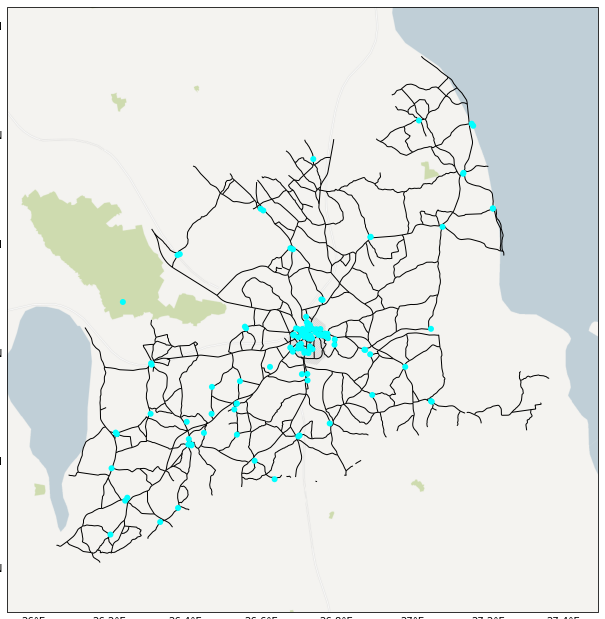

In [106]:
tiles.opts(zoom=10) * gv.Overlay(shapes).opts(projection=crs.GOOGLE_MERCATOR) * gv.Points(schools84).opts(color='cyan', projection=crs.GOOGLE_MERCATOR)

### global earth plots

In [125]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Land.I      :Feature   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (gdp_md_est)
   .Points.I    :Points   [Longitude,Latitude]
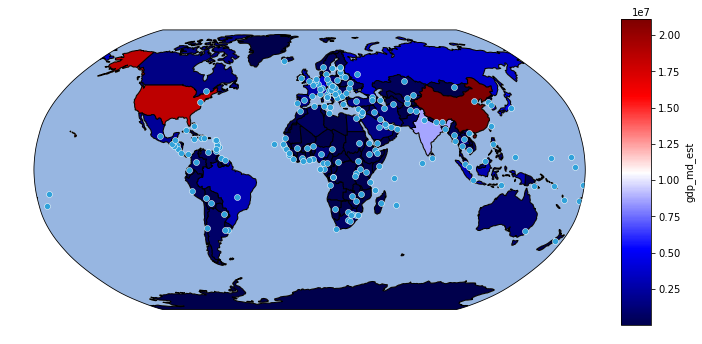

In [126]:
gf.ocean * gf.coastline * gf.land * gv.Polygons(countries, vdims=['gdp_md_est']).opts(colorbar=True, cmap='seismic', projection=crs.Robinson(), ) * gv.Points(cities).opts(edgecolor='white', lw=0.5, show_grid=False,
    show_frame=False, colorbar=False, fig_size=300)